## Amazon Food reviews set - Classifying food reviews

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. 

Variables included are:
- Row Id
- ProductId - Unique identifier for the product
- UserId - Unqiue identifier for the user
- ProfileName - Profile name of the user
- HelpfulnessNumerator - Number of users who found the review helpful
- HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not
- Score - Rating between 1 and 5
- Time - Timestamp for the review
- Summary - Brief summary of the review
- Text - Text of the review

The following notebooks will look at the data, create new features, do data exploration and adjust a logistic regression. The goal is to try to predict if a review is categorised as useful/helpful (1) or not useful/helpful (0) based on the helpfulness votes from the readers. 

#### Justification
Why would it be of interest to predict if a review is helpful or not?
Some of the reason include:
- New comments posted. This will help overcome cold start problem (reviews with no information) and re-rank of the products. 
- Find out if a reviewer is good, if they are reliable. If so then could give them some kind of stamp/reward. Thinking like what other companies do. Example airbnb
- Understand the factors from review (text/comments elements) that influences/convinces or put off people in purchasing the products (attractive of the products/ not attractive)
- Bot or false reviews identification 

#### Modelling process
The steps followed are split in 2 notebooks. 

Notebook 1 - Data Exploration and Manipulation:
1. Loading the data - first glimpe
1. Defining the data set - which observations will be included in the study and which ones will be left out
1. Defining the target - if a review is useful then 1 if not then 0
1. Feature engineering - creating new variables and adding them to the data set
1. Data exploration 
6. Conclusions

Notebook 2 - Classification Methodology:
1. Data preparation - subsetting the data set, changing data types and creating dummy variables for all the categorical features
2. Preparing train and test sets
3. Classification model - Logistic regression pipeline
4. Model performance
5. Quick look at a Random Forest
6. Conclusions

Notebook 3 - Scikit learn workflow - using a pipeline

Hope you have fun reading this, I certainly had fun doing it. :)

Let us start by calling all the relevant libraries needed. This is always the first step when doing things in Python. 

In [1]:
## Import all relevent libraries to analyse the data
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## This line makes sure that our graphs are rendered within the notebook
%matplotlib inline

sns.set(color_codes=True)

## Set options to display all columns
# pd.set_option("display.max_columns",None)

### 1. First glimpse of the data
Loading the data and having a first look. 
Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

In [2]:
raw_data = pd.read_csv('Reviews.csv')
print(raw_data.shape)
print(raw_data.head())

(568454, 10)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality can

In [6]:
print(raw_data.dtypes)

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object


In [7]:
raw_data[['ProductId', 'UserId']].describe().T[['count','unique']]

,count,unique
ProductId,568454,74258
UserId,568454,256059


### 2. Defining the data set

#### Removing reviews(rows) when Helpfulness Denominator = 0
There are 270,052 reviews where Helpfulness Denominator = 0, meaning the review had no votes saying if it was useful or not.

The following section is the exploration and deletion of the cases when Helpfulness Denominator <= 3; meaning removing the cases with less or 3 votes. Our final data set will only have products with reviews with greater than 3 votes 



In [8]:
# Total data points 
raw_data.columns
summary_data = raw_data[['HelpfulnessNumerator',
                         'HelpfulnessDenominator', 'Score']]
np.round(summary_data.describe(), 2).T[['count','mean', 'std', 'min', 'max']]

,count,mean,std,min,max
HelpfulnessNumerator,568454.0,1.74,7.64,0.0,866.0
HelpfulnessDenominator,568454.0,2.23,8.29,0.0,923.0
Score,568454.0,4.18,1.31,1.0,5.0


In [9]:
# Products reviews with no votes
np.round(summary_data[summary_data['HelpfulnessDenominator']==0].describe()
         , 2
        ).T[['count','mean', 'std', 'min', 'max']]

,count,mean,std,min,max
HelpfulnessNumerator,270052.0,0.00,0.00,0.0,0.0
HelpfulnessDenominator,270052.0,0.00,0.00,0.0,0.0
Score,270052.0,4.41,1.08,1.0,5.0


In [10]:
# Products reviews with at least 1 vote
np.round(summary_data[summary_data['HelpfulnessDenominator']!=0].describe()
         , 2
        ).T[['count','mean', 'std', 'min', 'max']]

,count,mean,std,min,max
HelpfulnessNumerator,298402.0,3.32,10.29,0.0,866.0
HelpfulnessDenominator,298402.0,4.25,11.06,1.0,923.0
Score,298402.0,3.98,1.46,1.0,5.0


From the 568,454 total reviews:
- 270,052 Reviews were HelpfulnessDenominator = 0 - will remove these as these products' reviews have no votes
- 298,402 Reviews were HelpfulnessDenominator != 0 - at least one vote

In [3]:
# 1st Filter of the data set
Helpfulness_data = raw_data[raw_data['HelpfulnessDenominator']!=0]
print(Helpfulness_data.shape)

(298402, 10)


#### Removing reviews(rows) when Helpfulness Denominator = 1, 2 or 3
After removing the reviews with Denominator = 0 , there are still reviews that do not have enough votes to give enough information about the usefulness of a review. Therefore these reviews were also removed from the data set. The following section is the exploration and deletion of these cases. 

In [4]:
Helpfulness_data['HelpfulnessDenominator'].value_counts().head()

1    112753
2     61482
3     34394
4     22306
5     14824
Name: HelpfulnessDenominator, dtype: int64

In [31]:
bins = [0, 1, 2, 3, 4, 1000]
labels = [1,2,3,4,'>=5']
Helpfulness_data['HelpfulnessDenominator_binned'] = pd.cut(Helpfulness_data['HelpfulnessDenominator']
                                                           , bins=bins
                                                           , labels=labels)

s = Helpfulness_data.groupby(pd.cut(Helpfulness_data['HelpfulnessDenominator'] 
                                ,bins=bins
                                ,labels=labels)).size()

print(s)

HelpfulnessDenominator
1      112753
2       61482
3       34394
4       22306
>=5     67467
dtype: int64


/var/folders/19/gng8wq0n5m5bjyrq4j4xr6s00000gn/T/ipykernel_64115/2498055864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Helpfulness_data['HelpfulnessDenominator_binned'] = pd.cut(Helpfulness_data['HelpfulnessDenominator']


<AxesSubplot:xlabel='HelpfulnessDenominator_binned', ylabel='count'>

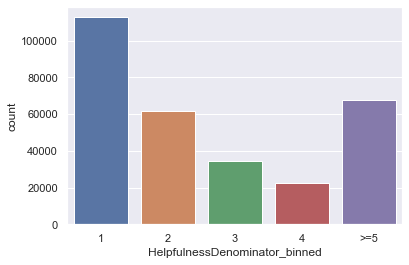

In [21]:
sns.countplot(x="HelpfulnessDenominator_binned", data = Helpfulness_data)

The count and graph from above show that there are some reviews with 1, 2 or 3 votes. The total cases are 208,629 (112753 + 61482 + 34394). 

In [29]:
## 2nd Filter of the data set
DenominatorBiggerthan3_data = raw_data[raw_data['HelpfulnessDenominator']>3]
DenominatorBiggerthan3_data.shape

(89773, 10)

**The final data set has 89,773 reviews.**

### 3. Defining the target
<p>Usefulness ratio = helpfulness_numerator / helpfulness_denominator</p>
Useful_flag = If usefulness > 0.7 then 1 (Useful) else 0 (Not Useful)

In [35]:
def target(ratio): 
    if ratio > 0.7: 
        return '1'
    return '0'

def calculate_helpfulness_ratio(Numerator, Denominator):
    ratio = Numerator/float(Denominator)
    useful_flag = target(ratio)
    ratio = round(ratio,2)
    return [ratio, useful_flag]

In [36]:
helpfulness_ratio = DenominatorBiggerthan3_data.apply(
    lambda x: pd.Series(
        calculate_helpfulness_ratio(x.HelpfulnessNumerator, x.HelpfulnessDenominator), 
        index = ["helpfulness_ratio", "useful_flag"]
    ),
    axis=1
)
HelpfulnesswithTarget_df = pd.concat([DenominatorBiggerthan3_data[:], helpfulness_ratio[:]], axis=1)
HelpfulnesswithTarget_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpfulness_ratio,useful_flag
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,1.0,1
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...,0.8,1
15,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,5,1262044800,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...,0.8,1
32,33,B001EO5QW8,AOVROBZ8BNTP7,S. Potter,19,19,4,1163376000,Best of the Instant Oatmeals,McCann's Instant Oatmeal is great if you must ...,1.0,1
33,34,B001EO5QW8,A3PMM0NFVEJGK9,"Megan ""Bad at Nicknames""",13,13,4,1166313600,Good Instant,This is a good instant oatmeal from the best o...,1.0,1


In this case, the target is being defined as useful (1) for ratios that are bigger than 0.7 However there are other ways of defining a target. For example, the target could actually be the usefulness ratio and the methodology will have to be chosen accordingly. Another way would be to set different levels of the usefulness, for example ratio levels can be set as: not useful/cannot say/ very useful. In this case the output would be a multiclass variable instead of a dummy response. 

### 4. Feature Engineering
Creating new features to enrich the data set. These include:
1. Score variables - feeling towards product
1. Text variables - text mining of review text
1. Time variables - variables extracted from timestamp
1. Product and reviewer variables

#### 4.1. Feature Engineering - Score variables
- Positive rating of a food product - flag
- Negative rating of a food product - flag

In [37]:
def get_rating_flags(score):
    def negative_rating(score):
        if score < 3:
            return '1'
        return '0'
    def positive_rating(score):
        if score > 3:
            return '1'
        return '0'
    negative = negative_rating(score)
    positive = positive_rating(score)
    return [negative, positive]

In [38]:
rating_flags = HelpfulnesswithTarget_df.apply(
    lambda x: pd.Series(
        get_rating_flags(x.Score), 
        index = ["negative_rating_flag", "positive_rating_flag"]
    ),
    axis=1
)
HelpfulnesswithTarget_df = pd.concat([HelpfulnesswithTarget_df[:], rating_flags[:]], axis=1)
HelpfulnesswithTarget_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpfulness_ratio,useful_flag,negative_rating_flag,positive_rating_flag
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,1.0,1,0,1
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...,0.8,1,0,1
15,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,5,1262044800,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...,0.8,1,0,1
32,33,B001EO5QW8,AOVROBZ8BNTP7,S. Potter,19,19,4,1163376000,Best of the Instant Oatmeals,McCann's Instant Oatmeal is great if you must ...,1.0,1,0,1
33,34,B001EO5QW8,A3PMM0NFVEJGK9,"Megan ""Bad at Nicknames""",13,13,4,1166313600,Good Instant,This is a good instant oatmeal from the best o...,1.0,1,0,1


#### 4.2. Feature Engineering - Text Variables
- Clean reviews
- Number of distinct words
- Number of total words
- Number of distinct cleaned words
- Number of total cleaned words
- Ratio of clean words / total words

Could have added:
- Sentiment Analysis or further text mining from the review or summary
- Number of nouns, adjectives and exclamation marks; plus ratio of these with the number of total words

In [39]:
## Importing NLP module
import nltk

In [40]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

from nltk.probability import FreqDist

def get_word_counts(text):
    tokenized_word=tokenizer.tokenize(text)
    fdist = FreqDist(tokenized_word)
    return [fdist.B(), fdist.N()]

In [41]:
text_attributes = HelpfulnesswithTarget_df.apply(
    lambda x: pd.Series(
        get_word_counts(x.Text), 
        index = ["n_distinct_words", "n_words"]
    ),
    axis=1
)
HelpfulnesswithTarget_df = pd.concat([HelpfulnesswithTarget_df[:], text_attributes[:]], axis=1)
#HelpfulnesswithTarget_df.head()

In [42]:
import re
import string
string.punctuation

number='0123456789'

## NOT TOKENISED REVIEW
## Text cleansing - removes punctuation and sets all text to lower case
def initial_clean(text):
   
    ##remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub("(\')",'',str(text))
    text = re.sub(r"(\W)",r' ',str(text))
    text = re.sub(r" +",r' ',str(text))
    text = re.sub("\/"," ",str(text))
    text = re.sub(r'\b\d+(?:\.\d+)?\s+','',str(text))
    text = re.sub('^[0-9 ]+', '', str(text))
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ",str(text))
    nopunct = text.lower()
    nonumb= "".join([char for char in nopunct if char not in number])
   
    return nonumb

## Test:
# Text_test = raw_data.loc[0,'Text'] 
# print(Text_test)
# print(initial_clean(Text_test))

In [44]:
from nltk.corpus import stopwords
#nltk.download('stopwords')
sr= stopwords.words('english')

## TOKENISED REVIEW INTO WORDS
## Text cleansing - removes punctuation and sets all text to lower case
def clean_data(text):
    text = text.lower()
    text = tokenizer.tokenize(text)
    text = [ word for word in text if word not in sr]
    return text

## Test:
# Text_test = raw_data.loc[0,'Text'] 
# print(Text_test)
# print(clean_data(Text_test))

# On data set:
# HelpfulnesswithTarget_df['Text'].apply(lambda x: clean_data(x))

HelpfulnesswithTarget_df['clean_text'] = HelpfulnesswithTarget_df.apply(lambda x:clean_data(x.Text), axis=1)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/CH10ZMB/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [45]:
def get_cleanword_counts(text):
    fdist = FreqDist(text)
    return [fdist.B(), fdist.N()]

clean_text_attributes = HelpfulnesswithTarget_df.apply(
    lambda x: pd.Series(
        get_cleanword_counts(x.clean_text), 
        index = ["n_distinct_cleanwords", "n_cleanwords"]
    ),
    axis=1
)
HelpfulnesswithTarget_df = pd.concat([HelpfulnesswithTarget_df[:], clean_text_attributes[:]], axis=1)
#HelpfulnesswithTarget_df.head()

In [46]:
HelpfulnesswithTarget_df['cleanwords_ratio'] = HelpfulnesswithTarget_df.n_cleanwords/HelpfulnesswithTarget_df.n_words

In [26]:
# Tags of the words
#nltk.pos_tag(clean_data(Text_test))

In [47]:
HelpfulnesswithTarget_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpfulness_ratio,useful_flag,negative_rating_flag,positive_rating_flag,n_distinct_words,n_words,clean_text,n_distinct_cleanwords,n_cleanwords,cleanwords_ratio
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,1.0,1,0,1,53,67,"[one, boys, needed, lose, weight, put, food, f...",25,31,0.462687
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...,0.8,1,0,1,20,21,"[strawberry, twizzlers, guilty, pleasure, yumm...",9,9,0.428571
15,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,5,1262044800,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...,0.8,1,0,1,23,26,"[daughter, loves, twizzlers, shipment, six, po...",14,16,0.615385
32,33,B001EO5QW8,AOVROBZ8BNTP7,S. Potter,19,19,4,1163376000,Best of the Instant Oatmeals,McCann's Instant Oatmeal is great if you must ...,1.0,1,0,1,129,206,"[mccann, instant, oatmeal, great, must, oatmea...",84,110,0.533981
33,34,B001EO5QW8,A3PMM0NFVEJGK9,"Megan ""Bad at Nicknames""",13,13,4,1166313600,Good Instant,This is a good instant oatmeal from the best o...,1.0,1,0,1,72,93,"[good, instant, oatmeal, best, oatmeal, brand,...",40,46,0.494624



#### 4.3. Feature Engineering - Time Variables
- Transform variable to the right format
- Day of the week variable
- Month variable
- Season flags - winter and summer
- Year variable - not enough reviews from all the years
- Daytime/Nightime/EarlyMorning - time stamp does not have the time attribute, just the date

Could add: special events or holiday flags

In [48]:
## Change timestamp format
# HelpfulnesswithTarget_df["Time"] = HelpfulnesswithTarget_df["Time"].map(lambda timestamp: pd.Timestamp(timestamp, unit="s"))
HelpfulnesswithTarget_df['Time'] = pd.to_datetime(HelpfulnesswithTarget_df['Time'], unit='s')
HelpfulnesswithTarget_df['day_of_week'] = HelpfulnesswithTarget_df['Time'].dt.weekday #+ 1
HelpfulnesswithTarget_df['year'] = HelpfulnesswithTarget_df['Time'].dt.year
HelpfulnesswithTarget_df['month'] = HelpfulnesswithTarget_df['Time'].dt.month
HelpfulnesswithTarget_df['hour'] = HelpfulnesswithTarget_df['Time'].dt.hour

HelpfulnesswithTarget_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,n_distinct_words,n_words,clean_text,n_distinct_cleanwords,n_cleanwords,cleanwords_ratio,day_of_week,year,month,hour
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,2010-08-27,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,...,53,67,"[one, boys, needed, lose, weight, put, food, f...",25,31,0.462687,4,2010,8,0
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,2010-03-12,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...,...,20,21,"[strawberry, twizzlers, guilty, pleasure, yumm...",9,9,0.428571,4,2010,3,0
15,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,5,2009-12-29,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...,...,23,26,"[daughter, loves, twizzlers, shipment, six, po...",14,16,0.615385,1,2009,12,0
32,33,B001EO5QW8,AOVROBZ8BNTP7,S. Potter,19,19,4,2006-11-13,Best of the Instant Oatmeals,McCann's Instant Oatmeal is great if you must ...,...,129,206,"[mccann, instant, oatmeal, great, must, oatmea...",84,110,0.533981,0,2006,11,0
33,34,B001EO5QW8,A3PMM0NFVEJGK9,"Megan ""Bad at Nicknames""",13,13,4,2006-12-17,Good Instant,This is a good instant oatmeal from the best o...,...,72,93,"[good, instant, oatmeal, best, oatmeal, brand,...",40,46,0.494624,6,2006,12,0


In [49]:
HelpfulnesswithTarget_df['hour'].value_counts().head() # hour is not recorded in the time stamp

0    89773
Name: hour, dtype: int64

In [50]:
del HelpfulnesswithTarget_df['hour']

In [51]:
def get_season_flags(month):
    def winter_flag(month):
        if month in [10, 11, 12 , 1, 2]:
            return '1'
        return '0'
    def summer_flag(month):
        if month in [7, 8]:
            return '1'
        return '0'
    winter = winter_flag(month)
    summer = summer_flag(month)
    return [winter, summer]

In [52]:
season_flags = HelpfulnesswithTarget_df.apply(
    lambda x: pd.Series(
        get_season_flags(x.month), 
        index = ["winter_flag", "summer_flag"]
    ),
    axis=1
)
HelpfulnesswithTarget_df = pd.concat([HelpfulnesswithTarget_df[:], season_flags[:]], axis=1)
HelpfulnesswithTarget_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,n_words,clean_text,n_distinct_cleanwords,n_cleanwords,cleanwords_ratio,day_of_week,year,month,winter_flag,summer_flag
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,2010-08-27,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,...,67,"[one, boys, needed, lose, weight, put, food, f...",25,31,0.462687,4,2010,8,0,1
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,2010-03-12,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...,...,21,"[strawberry, twizzlers, guilty, pleasure, yumm...",9,9,0.428571,4,2010,3,0,0
15,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,5,2009-12-29,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...,...,26,"[daughter, loves, twizzlers, shipment, six, po...",14,16,0.615385,1,2009,12,1,0
32,33,B001EO5QW8,AOVROBZ8BNTP7,S. Potter,19,19,4,2006-11-13,Best of the Instant Oatmeals,McCann's Instant Oatmeal is great if you must ...,...,206,"[mccann, instant, oatmeal, great, must, oatmea...",84,110,0.533981,0,2006,11,1,0
33,34,B001EO5QW8,A3PMM0NFVEJGK9,"Megan ""Bad at Nicknames""",13,13,4,2006-12-17,Good Instant,This is a good instant oatmeal from the best o...,...,93,"[good, instant, oatmeal, best, oatmeal, brand,...",40,46,0.494624,6,2006,12,1,0


#### 4.4. Feature Engineering - Product and reviewer variables
- Number of times product appears in reviews (product_freq)
- Number of times reviewer appears in reviews (reviewer_freq)

Could have added:
- average number of reviews per reviewer
- average number of reviews per product

In [53]:
## Counts per product
HelpfulnesswithTarget_df.ProductId.value_counts().head()

B000VK08OC    163
B003B3OOPA    148
B00012182G    124
B000FI4O90    121
B006Q820X0    118
Name: ProductId, dtype: int64

In [54]:
HelpfulnesswithTarget_df['product_freq'] = HelpfulnesswithTarget_df.groupby('ProductId')['ProductId'].transform('count')
HelpfulnesswithTarget_df.sort_values('product_freq', ascending=False).head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,clean_text,n_distinct_cleanwords,n_cleanwords,cleanwords_ratio,day_of_week,year,month,winter_flag,summer_flag,product_freq
292242,292243,B000VK08OC,AAFS750GGU1YF,GigiSez,11,11,5,2008-12-28,Best Manuka Honey on the Market,I have tried several brands of organic Manuka ...,...,"[tried, several, brands, organic, manuka, hone...",27,28,0.538462,6,2008,12,1,0,163
292257,292258,B000VK08OC,A2ZZ931SRYDDUR,MTNSURF20,8,8,5,2011-09-23,works well to prevent acid reflux...,I have dealt w reflux for most of my adult lif...,...,"[dealt, w, reflux, adult, life, 41, problems, ...",71,82,0.465909,4,2011,9,0,0,163
292267,292268,B000VK08OC,A1EZV8B8EZLWI4,Anthony A. Greenwood Jr.,7,7,5,2011-11-07,Miracle Food,I was diagnosed with esophageal ulcers and cou...,...,"[diagnosed, esophageal, ulcers, eat, swallow, ...",15,15,0.428571,0,2011,11,1,0,163
292266,292267,B000VK08OC,ARBR8471NTSMH,Filet Mignon,10,11,5,2011-03-06,Yummy in my Tummy,Them bees sure spit out a delicious concoction...,...,"[bees, sure, spit, delicious, concoction, eh, ...",125,192,0.536313,6,2011,3,0,0,163
292265,292266,B000VK08OC,A7EJERNB7IK3Z,CQ DX,10,11,5,2011-05-04,One of the 2 best honeys in the world! Helps ...,"I had read a few articles about Manuka honey, ...",...,"[read, articles, manuka, honey, supposed, medi...",63,80,0.500000,2,2011,5,0,0,163


In [55]:
## Counts per reviewer
HelpfulnesswithTarget_df.UserId.value_counts().head()

A3TVZM3ZIXG8YW    174
A1YUL9PCJR3JTY    125
A281NPSIMI1C2R    107
A29JUMRL1US6YP    102
A1WX42M589VAMQ     78
Name: UserId, dtype: int64

In [56]:
HelpfulnesswithTarget_df['reviewer_freq'] = HelpfulnesswithTarget_df.groupby('UserId')['UserId'].transform('count')
HelpfulnesswithTarget_df.sort_values('reviewer_freq', ascending=False).head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,n_distinct_cleanwords,n_cleanwords,cleanwords_ratio,day_of_week,year,month,winter_flag,summer_flag,product_freq,reviewer_freq
318797,318798,B003MW7858,A3TVZM3ZIXG8YW,christopher hayes,7,9,1,2010-12-04,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",...,273,434,0.488189,5,2010,12,1,0,27,174
499864,499865,B009B87SAC,A3TVZM3ZIXG8YW,christopher hayes,33,48,1,2010-12-04,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",...,273,434,0.488189,5,2010,12,1,0,27,174
282911,282912,B002Z9EQPO,A3TVZM3ZIXG8YW,christopher hayes,7,11,1,2010-12-04,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",...,273,434,0.488189,5,2010,12,1,0,5,174
247121,247122,B003M5TG28,A3TVZM3ZIXG8YW,christopher hayes,6,14,1,2010-12-04,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",...,273,434,0.488189,5,2010,12,1,0,27,174
429240,429241,B003MWBFMK,A3TVZM3ZIXG8YW,christopher hayes,7,9,1,2010-12-04,"Filler food is empty, leaves your cat always n...","This review will make me sound really stupid, ...",...,273,434,0.488189,5,2010,12,1,0,27,174


### 5. Data Exploration

This section includes plots and graphs from the data set with the variables created from the previous section. Plus their comparison with the target variable. It gives an idea of which are the important variables in the model. It also helpsdecide which variables to take out of the study and it also helps create more variables if needed. 

The data set at this point includes:
- Reviews from Oct 2001 - Oct 2012
- 89,773 reviews
- 51,702 users
- 22,747 products

Exploration includes:
1. Looking at the target variable
2. Numeric variable means related to target variable
3. Data Exploration - Rating and Score variables
4. Reviews and products per year
5. Reviews and products per month and days of the week

In [57]:
HelpfulnesswithTarget_df[['ProductId', 'UserId']].describe().T[['count','unique']]
# HelpfulnesswithTarget_df.ProductId.nunique()

,count,unique
ProductId,89773,22747
UserId,89773,51702


In [58]:
print(HelpfulnesswithTarget_df.dtypes)

Id                                 int64
ProductId                         object
UserId                            object
ProfileName                       object
HelpfulnessNumerator               int64
HelpfulnessDenominator             int64
Score                              int64
Time                      datetime64[ns]
Summary                           object
Text                              object
helpfulness_ratio                float64
useful_flag                       object
negative_rating_flag              object
positive_rating_flag              object
n_distinct_words                   int64
n_words                            int64
clean_text                        object
n_distinct_cleanwords              int64
n_cleanwords                       int64
cleanwords_ratio                 float64
day_of_week                        int64
year                               int64
month                              int64
winter_flag                       object
summer_flag     

In [59]:
HelpfulnesswithTarget_df['day_of_week'] = HelpfulnesswithTarget_df['day_of_week'].astype('category') 
HelpfulnesswithTarget_df['year'] = HelpfulnesswithTarget_df['year'].astype('category') 
HelpfulnesswithTarget_df['month'] = HelpfulnesswithTarget_df['month'].astype('category') 

#### 5.1. Data Exploration - Looking at the target variable

When having a look at the target variable, it is possible to see that there are more 1's than 0's. This imbalance will need to be corrected so that the model ingests balanced data as this will help with performance and will give robustness to our model 

/Users/CH10ZMB/projects/PythonExamples/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

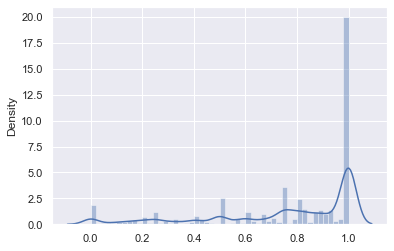

In [64]:
sns.distplot(HelpfulnesswithTarget_df[['helpfulness_ratio']],kde=True, rug=False)
#plt.hist(HelpfulnesswithTarget_df[['helpfulness_ratio']])

1    62987
0    26786
Name: useful_flag, dtype: int64


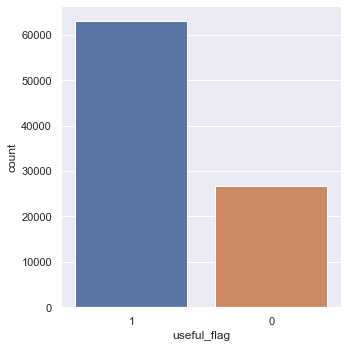

In [65]:
print(HelpfulnesswithTarget_df['useful_flag'].value_counts().head())
sns.catplot(x="useful_flag", kind="count", data = HelpfulnesswithTarget_df)

#### 5.2. Data Exploration - Numeric variable means related to target variable

In [66]:
for_exploration = HelpfulnesswithTarget_df[['useful_flag'
                                           ,'helpfulness_ratio'
                                           ,'Score'
                                           ,'negative_rating_flag'
                                           ,'positive_rating_flag'
                                           ,'n_distinct_words'
                                           ,'n_distinct_cleanwords'
                                           ,'n_words'
                                           ,'n_cleanwords'
                                           ,'cleanwords_ratio'
                                           ,'product_freq'
                                           ,'reviewer_freq']]

for_exploration.groupby('useful_flag').mean()

,helpfulness_ratio,Score,n_distinct_words,n_distinct_cleanwords,n_words,n_cleanwords,cleanwords_ratio,product_freq,reviewer_freq
useful_flag,,,,,,,,,
0,0.366388,2.313037,64.606996,38.686105,96.078399,48.769581,0.501308,18.630143,5.731614
1,0.925228,4.143268,78.857034,48.548351,121.142236,62.139314,0.506926,15.267277,5.747853


Just by looking at this mean table for the numerical and ordinal features it is possible to see that Score might end up being an important variable to distinct between the two outcomes. This, because useful reviews have products which on average got higher scores (4.1) and not useful reviews have products which on average have lower product ratings (2.3) 
The plots displayed in the follwing section also show a clear difference. 

#### 5.3. Data Exploration - Rating and Score variables


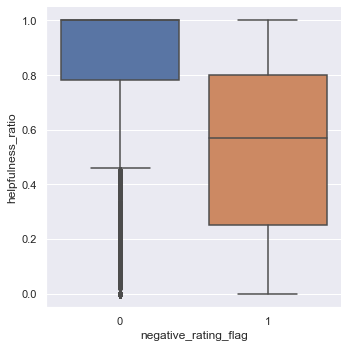

In [67]:
HelpfulnesswithTarget_df['negative_rating_flag'].value_counts().head()
sns.catplot(x="negative_rating_flag", y="helpfulness_ratio", kind="box", data=HelpfulnesswithTarget_df)

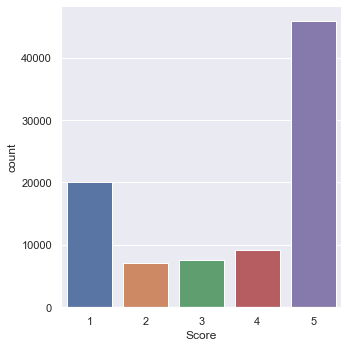

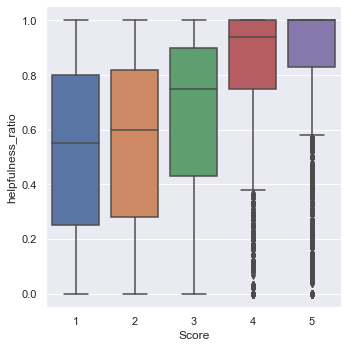

In [69]:
## Score Histograms
## Seaborn histogram
sns.catplot(x="Score", kind="count", data = HelpfulnesswithTarget_df)
sns.catplot(x="Score", y="helpfulness_ratio", kind="box", data=HelpfulnesswithTarget_df)

#### 5.4. Data Exploration - Reviews and products per year
When having a closer look at the years, this variable does not seem to be a good candidate for the model since there are not enough reviews from across all years and introducing it might bring bias to the model. 

2011    22720
2010    19260
2009    14185
2008     9955
2012     9762
2007     8980
2006     3673
2005      759
2004      342
2003       81
2002       37
2000       12
2001        7
Name: year, dtype: int64


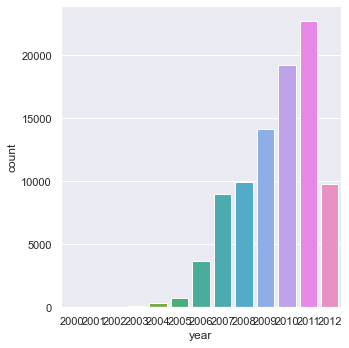

In [70]:
## Reviews per year
print(HelpfulnesswithTarget_df['year'].value_counts())
sns.catplot(x="year", kind="count", data = HelpfulnesswithTarget_df) # reviews per year

In [71]:
## Distinct products per year
HelpfulnesswithTarget_df.groupby('year').ProductId.nunique()

# print(pd.crosstab(HelpfulnesswithTarget_df.year
#             ,HelpfulnesswithTarget_df.ProductId
#            ).ne(0).mean(1))

year
2000       7
2001       4
2002      12
2003      73
2004     244
2005     572
2006    1927
2007    4290
2008    5175
2009    7002
2010    8825
2011    9545
2012    4354
Name: ProductId, dtype: int64

#### 5.5. Data Exploration - Reviews and products per month and days of the week
From the plots, the day of the week variables might not bring too much into the model as there is not a clear difference between the usefulness ratio and the useful flag. However, the month variable shows a bit more potential with some spikes on reviews, specially for January (winter month) and the cold months and slightly on March and May. 

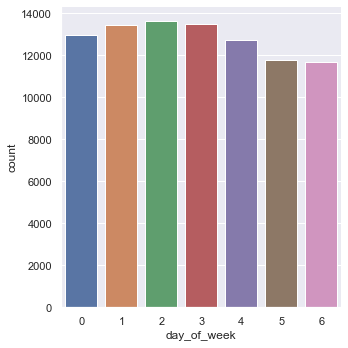

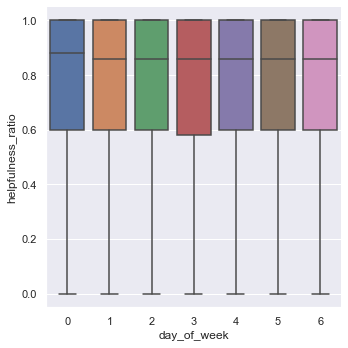

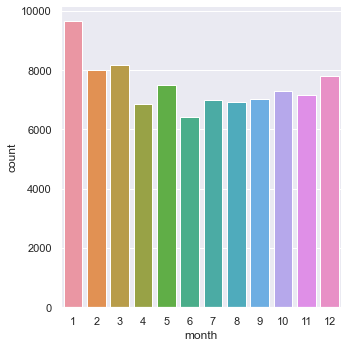

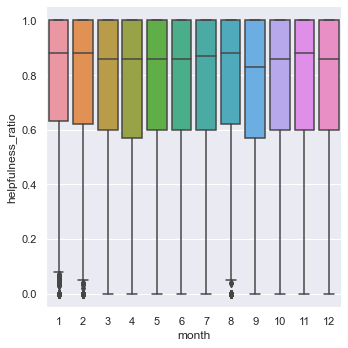

In [72]:
sns.catplot(x="day_of_week", kind="count", data = HelpfulnesswithTarget_df) #, ax=axes[0][0])
sns.catplot(x="day_of_week", y="helpfulness_ratio", kind="box", data=HelpfulnesswithTarget_df) #, ax=axes[0][1])
sns.catplot(x="month", kind="count", data = HelpfulnesswithTarget_df) #, ax=axes[1][0])
sns.catplot(x="month", y="helpfulness_ratio", kind="box", data=HelpfulnesswithTarget_df) #, ax=axes[1][1])

Text(0, 0.5, 'Reviews')

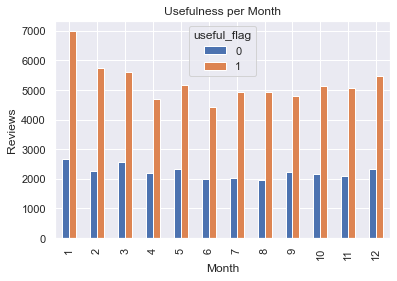

In [73]:
pd.crosstab(HelpfulnesswithTarget_df.month,HelpfulnesswithTarget_df.useful_flag).plot(kind='bar')
plt.title('Usefulness per Month')
plt.xlabel('Month')
plt.ylabel('Reviews')

# plt.savefig('usefulness_perMonth')

In [74]:
# Correlation - Scatter plot
# print(HelpfulnesswithTarget_df.columns)
# correlation_df=HelpfulnesswithTarget_df[[ 'helpfulness_ratio'
#                                          ,'Score'
#                                          ,'n_distinct_words'
#                                          ,'n_distinct_cleanwords'
#                                          ,'n_words'
#                                          ,'n_cleanwords']]
# correlation_df.corr(method='pearson')

In [75]:
#seaborn scatter plot
#sns.pairplot(correlation_df)

# matplotlib scatter plot
# fig, ax = plt.subplots()
# ax.scatter(delta1[:-1], delta1[1:], c=close, s=volume, alpha=0.5)

In [78]:
[col for col in HelpfulnesswithTarget_df]

['Id',
 'ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text',
 'helpfulness_ratio',
 'useful_flag',
 'negative_rating_flag',
 'positive_rating_flag',
 'n_distinct_words',
 'n_words',
 'clean_text',
 'n_distinct_cleanwords',
 'n_cleanwords',
 'cleanwords_ratio',
 'day_of_week',
 'year',
 'month',
 'winter_flag',
 'summer_flag',
 'product_freq',
 'reviewer_freq']

#### Saving the data set for section 2

In [77]:
HelpfulnesswithTarget_df.to_csv('HelpfulnesswithTarget_df.csv')

### 6. Conclusions from 1
- Data. Could have renamed the variables to make them more intuitive
- Data. I didn't considered product or reviewer popularity when removing the reviews with no votes and for the rest of the analysis which is something that sould probably be considered.
- Target. The 0.7 threshold of the target is arbitrary and I could have predicted the ratio as well to avoid this, but I wanted to try logistic regression as I haven't done it in a while. 
- Variables. Could have added more variables. For example, variables that have to do with sentiment analysis of the review or words used or topic modelling
- Workflow. In practice, Number 4 (Feature Engineering) and 5 (Data Exploration) are created almost in parallel. The more one explores the data the more features one comes up with until the final data set is as complete as possible. 
- Rating flags. I did not consider Score = 3 as I consider this is does not say if a person has negative or positive review of the product